In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from itertools import combinations
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class CompareOccupations:
    def __init__(self,all_people_csv="all_people.csv", occupations_csv="occupations.csv", numOfWorkers_csv="numOfWorkers.csv"):
        self.tab_colors=['tab:blue','tab:red','tab:green','tab:purple','tab:brown','tab:orange','tab:pink','tab:gray','tab:cyan','tab:olive']
        self.df_all_people=pd.read_csv(all_people_csv)
        self.df_occupations=pd.read_csv(occupations_csv).set_index('key')
        self.occLabels_dict=self.df_occupations.to_dict()
        self.workers_per_year=self.__countWorkersPerYear__()
        self.min_year=self.check_min_year()

    def check_min_year(self):
        output=100000
        for index, row in self.df_all_people.iterrows():
            if row['YOB']!=-10000:
                output=min(output,row['YOB'])
        return output

    def __countWorkersPerYear__(self):
        output={}
        for index, row in self.df_all_people.iterrows():
            if row['YOB']!=-10000:
                yearWork=row['YOB']+18
                yearDead=row['YOD']
                for i in range(yearWork,min(yearDead,2022)+1):
                    output[i]=output[i]+1 if i in output else 1
        return output

    def __get_numberOfOccupiers__(self, occs,year_from=-9999,year_to=5000):
        year_from=self.min_year if year_from==-9999 else year_from
        output=np.asarray([0]*(year_to-year_from+1))
        for index, row in self.df_all_people.iterrows():
            if row['YOB']==-10000:
                continue
            is_valid=True
            for occ in occs:
                if occ not in row['occupations']:
                    is_valid=False
                    break
            if is_valid:
                yearWork=row['YOB']+18
                yearDead=row['YOD']
                for i in range(yearWork,yearDead+1):
                    if year_from<=i<=year_to:
                        output[i-year_from]+=1
        return output

    def __get_numberOfOccupiersForEachOcc__(self,occs,year_from=-9999,year_to=5000):
        year_from=self.min_year if year_from==-9999 else year_from
        output={}
        for occ in occs:
            output[occ]=np.asarray([0]*(year_to-year_from+1))
        for index, row in self.df_all_people.iterrows():
            for occ in occs:
                if occ in row['occupations']:
                    yearWork=row['YOB']+18
                    yearDead=row['YOD']
                    for i in range(yearWork,yearDead+1):
                        if year_from<=i<=year_to:
                            output[occ][i-year_from]+=1

        return output

    def __get_allOccupiers__(self,occs,year_from=-9999,year_to=5000):
        year_from=self.min_year if year_from==-9999 else year_from
        output= set([])
        for index, row in self.df_all_people.iterrows():
            if not(row['YOB']+18>=year_to or row['YOD']<=year_from):
                is_valid=True
                for occ in occs:
                    if occ not in row['occupations']:
                        is_valid=False
                        break
                if is_valid:
                    output.add(row[0])
        return output

    def __get_allCombs__(self,year_from=-9999,year_to=5000):
        year_from=self.min_year if year_from==-9999 else year_from
        output= {}
        for index, row in self.df_all_people.iterrows():
            if not(row['YOB']+18>=year_to or row['YOD']<=year_from):
                # print(list(row['occupations'][2:-2].split("', '")))
                # print(list(combinations(row['occupations'], 2)))
                if row['YOB']!=-10000:
                    for occs in list(combinations(list(row['occupations'][2:-2].split("', '")), 2)):
                        output[occs]=output[occs]+1 if occs in output else 1
        return output


    def create_comparison_between(self,occs,year_from=-9999,year_to=2022):
        year_from=self.min_year if year_from==-9999 else year_from
        ret=self.__get_numberOfOccupiersForEachOcc__(occs,year_from,year_to)
        normalizer=[]
        for i in range(year_from,year_to+1):
            normalizer.append(self.workers_per_year[i])
        plt.figure(1,figsize=(20,5))
        for key,c in zip(ret.keys(),self.tab_colors):
            normed=ret[key]/normalizer
            plt.plot(range(year_from,year_to+1),normed,color=c,label=self.occLabels_dict['itemLabel'][key])
            plt.fill_between(range(year_from,year_to+1),normed,color=c,alpha= 0.3)
        plt.legend()
        plt.title(f"({' vs '.join([self.occLabels_dict['itemLabel'][oc] for oc in occs])}) ({year_from}-{year_to})")
        plt.savefig(f"({' vs '.join([self.occLabels_dict['itemLabel'][oc] for oc in occs])}) ({year_from}-{year_to})")

    def create_statistics_of(self,occs,year_from=-9999,year_to=2022):
        year_from=self.min_year if year_from==-9999 else year_from
        ret=self.__get_numberOfOccupiers__(occs,year_from,year_to)
        normalizer=[]
        for i in range(year_from,year_to+1):
            normalizer.append(self.workers_per_year[i])
        plt.figure(1,figsize=(20,5))

        normed=ret/normalizer
        plt.plot(range(year_from,year_to+1),normed,color=self.tab_colors[0])
        plt.fill_between(range(year_from,year_to+1),normed,color=self.tab_colors[0],alpha= 0.3)
        plt.title(f"({' & '.join([self.occLabels_dict['itemLabel'][oc] for oc in occs])}) ({year_from}-{year_to})")
        plt.savefig(f"({' & '.join([self.occLabels_dict['itemLabel'][oc] for oc in occs])}) ({year_from}-{year_to})")

    def create_graph_between(self,year_from=-9999,year_to=2022,min_connections=1,notebook=False):
        year_from=self.min_year if year_from==-9999 else year_from
        nx_graph = Network('1800px','900px',notebook=notebook)
        ret=self.__get_allCombs__(year_from,year_to)
        for Q1,Q2 in ret.keys():
            if ret[(Q1,Q2)]>=min_connections:
                Q1_label= self.occLabels_dict['itemLabel'][Q1]
                Q2_label= self.occLabels_dict['itemLabel'][Q2]
                nx_graph.add_node(Q1_label)
                nx_graph.add_node( Q2_label)
                nx_graph.add_edge(Q1_label, Q2_label, value=ret[(Q1,Q2)])
        nx_graph.show_buttons(filter_=['physics'])
        nx_graph.show(f'Graph ({year_from}-{year_to})(min_connections>{min_connections-1}).html')


Creating an instance of the class

In [3]:
cl=CompareOccupations()

## Note:
**In order to find the Q-code of the relevant occupation please use the 'df_occ_joined_counts_clean.csv' file**

#### Create a graph comparing different occupations in a time interval
**Input:** occupations: list, year_from: int, year_to: int

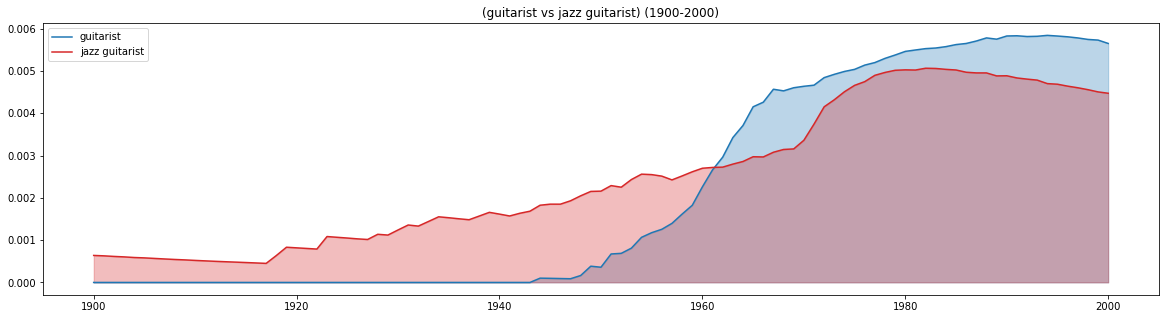

In [4]:
cl.create_comparison_between(['Q855091','Q6168364'],1900,2000)

#### Create a histogram of occupiers in a certain combination during a time interval
**Input:** occupations: list, year_from: int, year_to: int
**Note:** this is a combination of occupations, meaning there is a connection of 'and' between the different occupations

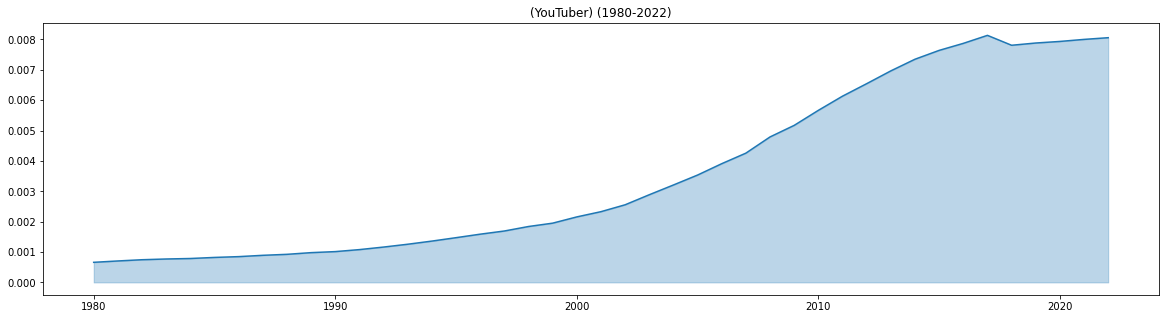

In [5]:
cl.create_statistics_of(['Q17125263'],1980,2022)

#### Create a nodes graph connections between different occupations
**Input:** year_from: int, year_to: int, min_connections: int (default is 1)
**Note**: The graph is saved under the current folder as a .html

In [6]:
cl.create_graph_between(1900,2000,7)